# Создание классов датасетов российских дорожных знаков (RTSD)

In [1]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import warnings
warnings.filterwarnings('ignore')
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### DATASET DETECT

In [2]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 1
classes = 2
device

'cpu'

#### pandas

In [3]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [4]:
df_train_anno = dataset('.', 'train_anno.json')
df_val_anno = dataset('.', 'val_anno.json')
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')

In [5]:
# Приведем все знаки к одному классу
df_train_anno_1 = df_train_anno.copy()
df_train_anno_1['category_id'] = 1

df_val_anno_1 = df_val_anno.copy()
df_val_anno_1['category_id'] = 1

df_train_anno_reduced_1 = df_train_anno_reduced.copy()
df_train_anno_reduced_1['category_id'] = 1

In [9]:
class RTSD_dataset_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
      
        boxes = []
        for b in self.df.loc[index,'bbox']:
            bb = [b[0], b[1], b[0] + b[2], b[1] + b[3]]
            boxes.append(bb)   

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.Tensor(self.df.loc[index, 'category_id']).to(torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id'][0]])
        
        areas = []
        for i in self.df.loc[index,'area']:
            areas.append(self.df.loc[index,'area'])
        areas = torch.as_tensor(areas[0], dtype=torch.float32)
       
        iscrowd = torch.zeros(len(self.df.loc[index,'iscrowd'])).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        
        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [6]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [7]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
df1 = RTSD_dataset_my('./', df_train_anno_reduced_1,transforms=get_transform())
df11 = RTSD_dataset_my('./', df_val_anno_1,transforms=get_transform())

In [11]:
data_loader_train1 = torch.utils.data.DataLoader(df1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val1 = torch.utils.data.DataLoader(df11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

In [12]:
 df1.__getitem__(100)

(tensor([[[2.8451e-03, 2.8451e-03, 2.8451e-03,  ..., 3.9216e-03,
           3.9216e-03, 3.9216e-03],
          [2.8297e-03, 2.8297e-03, 2.8451e-03,  ..., 3.9216e-03,
           3.9216e-03, 3.9216e-03],
          [2.8297e-03, 2.8297e-03, 2.8758e-03,  ..., 3.9216e-03,
           3.9216e-03, 3.9216e-03],
          ...,
          [2.6144e-04, 2.4606e-04, 2.6144e-04,  ..., 1.7378e-03,
           1.6917e-03, 1.6455e-03],
          [2.3068e-04, 2.3068e-04, 2.3068e-04,  ..., 1.6609e-03,
           1.6301e-03, 1.5994e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[3.6448e-03, 3.6448e-03, 3.6448e-03,  ..., 3.8908e-03,
           3.8908e-03, 3.8908e-03],
          [3.6294e-03, 3.6294e-03, 3.6448e-03,  ..., 3.8908e-03,
           3.8908e-03, 3.8908e-03],
          [3.6294e-03, 3.6294e-03, 3.6448e-03,  ..., 3.8908e-03,
           3.8908e-03, 3.8908e-03],
          ...,
          [6.1515e-04, 5.9977e-04, 5.8439e-04,  ..., 1.968

In [11]:
# функция загрузки датасета minmax
def dataset_1_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['xmin'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['ymin'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['xmax'] = df_mask.bbox.apply(lambda x: x[0]+x[2])
    df_mask['ymax'] = df_mask.bbox.apply(lambda x: x[1]+x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [12]:
train = dataset_1_mask('.', 'train_anno.json')
val = dataset_1_mask('.', 'val_anno.json')
reduced = dataset_1_mask('.', 'train_anno.json')
train.head()

,file_name,width,height,category_id,xmin,ymin,xmax,ymax,bbox,id,image_id,area,iscrowd,name
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,1280,720,1,649,376,667,394,"[649, 376, 18, 18]",0,0,324,0,2_1
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,1280,720,1,671,356,691,377,"[671, 356, 20, 21]",1,1,420,0,2_1
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,1280,720,1,711,332,738,358,"[711, 332, 27, 26]",2,2,702,0,2_1
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,764,290,801,326,"[764, 290, 37, 36]",3,3,1332,0,2_1
4,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,684,384,701,401,"[684, 384, 17, 17]",4,3,289,0,1_23


In [50]:
# # the dataset class
# class MicrocontrollerDataset(Dataset):
#     def __init__(self, dir_path, width, height, classes, transforms=None):
#         self.transforms = transforms
#         self.dir_path = dir_path
#         self.height = height
#         self.width = width
#         self.classes = classes
        
#         # get all the image paths in sorted order
#         self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
#         self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
#         self.all_images = sorted(self.all_images)
#     def __getitem__(self, idx):
#         # capture the image name and the full image path
#         image_name = self.all_images[idx]
#         image_path = os.path.join(self.dir_path, image_name)
#         # read the image
#         image = cv2.imread(image_path)
#         # convert BGR to RGB color format
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image_resized = cv2.resize(image, (self.width, self.height))
#         image_resized /= 255.0
        
#         # capture the corresponding XML file for getting the annotations
#         annot_filename = image_name[:-4] + '.xml'
#         annot_file_path = os.path.join(self.dir_path, annot_filename)
        
#         boxes = []
#         labels = []
#         tree = et.parse(annot_file_path)
#         root = tree.getroot()
        
#         # get the height and width of the image
#         image_width = image.shape[1]
#         image_height = image.shape[0]
        
#         # box coordinates for xml files are extracted and corrected for image size given
#         for member in root.findall('object'):
#             # map the current object name to `classes` list to get...
#             # ... the label index and append to `labels` list
#             labels.append(self.classes.index(member.find('name').text))
            
#             # xmin = left corner x-coordinates
#             xmin = int(member.find('bndbox').find('xmin').text)
#             # xmax = right corner x-coordinates
#             xmax = int(member.find('bndbox').find('xmax').text)
#             # ymin = left corner y-coordinates
#             ymin = int(member.find('bndbox').find('ymin').text)
#             # ymax = right corner y-coordinates
#             ymax = int(member.find('bndbox').find('ymax').text)
            
#             # resize the bounding boxes according to the...
#             # ... desired `width`, `height`
#             xmin_final = (xmin/image_width)*self.width
#             xmax_final = (xmax/image_width)*self.width
#             ymin_final = (ymin/image_height)*self.height
#             yamx_final = (ymax/image_height)*self.height
            
#             boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
#         # bounding box to tensor
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         # area of the bounding boxes
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # no crowd instances
#         iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
#         # labels to tensor
#         labels = torch.as_tensor(labels, dtype=torch.int64)
#         # prepare the final `target` dictionary
#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["area"] = area
#         target["iscrowd"] = iscrowd
#         image_id = torch.tensor([idx])
#         target["image_id"] = image_id
#         # apply the image transforms
#         if self.transforms:
#             sample = self.transforms(image = image_resized,
#                                      bboxes = target['boxes'],
#                                      labels = labels)
#             image_resized = sample['image']
#             target['boxes'] = torch.Tensor(sample['bboxes'])
            
#         return image_resized, target
#     def __len__(self):
#         return len(self.all_images)

### Аргументация

In [51]:
class RTSD_dataset_my_a(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
        img = np.array(img)
      
        boxes = []
        for b in self.df.loc[index,'bbox']:
            bb = [b[0], b[1], b[0] + b[2], b[1] + b[3]]
            boxes.append(bb)   

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.Tensor(self.df.loc[index, 'category_id']).to(torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id'][0]])
        
        areas = []
        for i in self.df.loc[index,'area']:
            areas.append(self.df.loc[index,'area'])
        areas = torch.as_tensor(areas[0], dtype=torch.float32)
       
        iscrowd = torch.zeros(len(self.df.loc[index,'iscrowd'])).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img = self.transforms(img)

        if self.transforms:
                    sample = self.transforms(image = img,
                                             bboxes =  my_annotation['boxes'],
                                             labels = labels)
                    img = sample['image']
                    my_annotation['boxes'] = torch.Tensor(sample['bboxes'])
        
        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [52]:
# bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])

In [53]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.MotionBlur(blur_limit=3, p=0.2),
        A.Blur(blur_limit=3, p=0.1),
        A.RandomBrightnessContrast(
            brightness_limit=0.2, p=0.5
        ),
        A.ColorJitter(p=0.5),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [54]:
df2 = RTSD_dataset_my_a('./', df_train_anno_reduced_1,transforms=get_train_transform())
df22 = RTSD_dataset_my_a('./', df_val_anno_1,transforms=get_valid_transform())

In [55]:
data_loader_train2 = torch.utils.data.DataLoader(df2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val2 = torch.utils.data.DataLoader(df22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)


In [56]:
df20 = RTSD_dataset_my_a('./', df_train_anno_reduced_1,transforms=get_valid_transform())
df220 = RTSD_dataset_my_a('./', df_val_anno_1,transforms=get_train_transform())

In [57]:
df_all = torch.utils.data.ConcatDataset([df20, df220])

In [58]:
data_loader_train20 = torch.utils.data.DataLoader(df_all,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val20 = torch.utils.data.DataLoader(df220,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)


In [59]:
len(data_loader_train20), len(data_loader_train2)

(6889, 1889)

In [34]:
def build_model(n_model, classes):
    if 'resnet50_fpn_v2' in n_model:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1')
    elif 'resnet50_fpn' in n_model:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.COCO_V1")
    else:
        print("нет такой модели ")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
    
    return model

In [35]:
model = build_model('resnet50_fpn', classes).to(device)
params1 = [p for p in model.parameters() if p.requires_grad]
optimizer1 = torch.optim.Adam(params1, lr=0.001)

In [36]:
images,targets = next(iter(data_loader_train20))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   
output

{'loss_classifier': tensor(0.6548, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0462, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0439, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0138, grad_fn=<DivBackward0>)}

In [30]:
def show_tranformed_image7(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
#             sample = sample * 255
#             sample = sample.astype(np.uint8)
            ax.imshow(sample)
            for box in boxes:
                          x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
                          rect = patches.Rectangle((x, y),
                                                  width, height,
                                                  fc ='none', 
                                                  ec ='r',
                                                  lw = 3)
                          ax.add_patch(rect)
            plt.axis('off')
            plt.show()

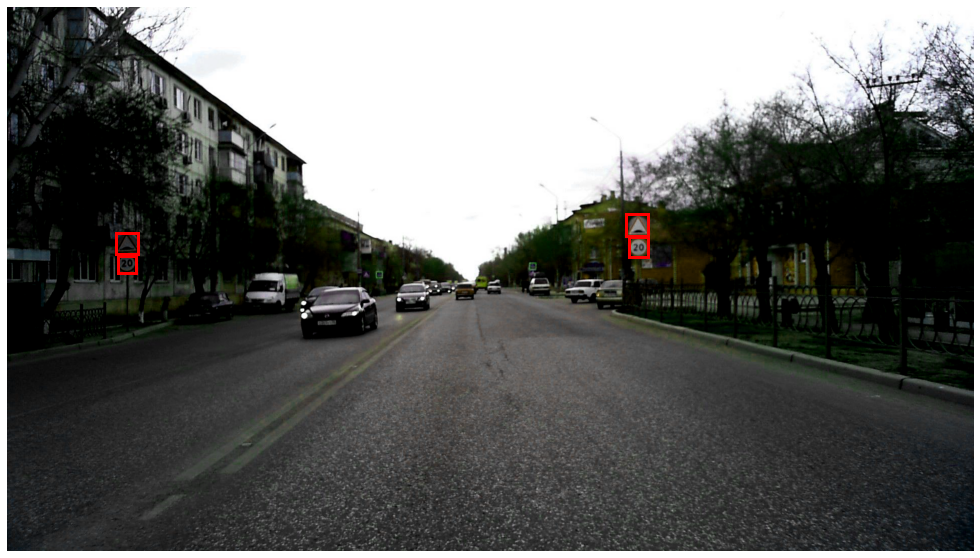

In [31]:
%matplotlib inline
show_tranformed_image7(data_loader_train20)

In [8]:
# функция загрузки датасета в pd
def dataset_2_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['x'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['y'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['w'] = df_mask.bbox.apply(lambda x: x[2])
    df_mask['h'] = df_mask.bbox.apply(lambda x: x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'x', 'y', 'w', 'h', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [9]:
train1 = dataset_2_mask('.', 'train_anno.json')
val1 = dataset_2_mask('.', 'val_anno.json')
reduced1 = dataset_2_mask('.', 'train_anno.json')
train1.head()

,file_name,width,height,category_id,x,y,w,h,bbox,id,image_id,area,iscrowd,name
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,1280,720,1,649,376,18,18,"[649, 376, 18, 18]",0,0,324,0,2_1
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,1280,720,1,671,356,20,21,"[671, 356, 20, 21]",1,1,420,0,2_1
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,1280,720,1,711,332,27,26,"[711, 332, 27, 26]",2,2,702,0,2_1
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,764,290,37,36,"[764, 290, 37, 36]",3,3,1332,0,2_1
4,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,684,384,17,17,"[684, 384, 17, 17]",4,3,289,0,1_23


In [27]:
# class PotHoleDataset(Dataset):
#     def __init__(self, dataframe, path_img, transforms=None):
#         super().__init__()
#         self.image_ids = dataframe['image_id'].unique()
#         self.df = dataframe
#         self.image_dir = path_img
#         self.transforms = transforms
        
#     def __getitem__(self, index: int):
#         image_id = self.image_ids[index]
#         records = self.df[self.df['image_id'] == image_id]
#         image = cv2.imread(f"{self.image_dir}/{self.df.file_name[index]}", cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
#         image /= 255.0
    
#         # convert the boxes into x_min, y_min, x_max, y_max format
#         boxes = records[['x', 'y', 'w', 'h']].values
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
#         # get the area of the bounding boxes
# #         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
# #         area = torch.as_tensor(area, dtype=torch.float32)
#         area = torch.as_tensor(self.df.loc[index,'area'], dtype=torch.float32)
        
#         # we have only one class
# #         labels = torch.ones((records.shape[0],), dtype=torch.int64)
#         labels = torch.Tensor(self.df.loc[index, 'category_id']).to(torch.int64)
#         # supposing that all instances are not crowd
#         iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        
#         target = {}
#         target['boxes'] = boxes
#         target['labels'] = labels
#         target['image_id'] = torch.tensor([index])
#         target['area'] = area
#         target['iscrowd'] = iscrowd
#         # apply the image transforms
#         if self.transforms:
#             sample = {
#                 'image': image,
#                 'bboxes': target['boxes'],
#                 'labels': labels
#             }
#             sample = self.transforms(**sample)
#             image = sample['image']
            
#             # convert the bounding boxes to PyTorch `FloatTensor`
#             target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, 
#                                                     zip(*sample['bboxes'])))).permute(1, 0)
        
#         return image, target
    
#     def __len__(self):
#         return self.image_ids.shape[0]

#### COCO

In [27]:
def anno_1_class(anno_file):
 
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    f.close()

    return anno_json

In [28]:
def anno_train_test_split(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as file1:
        anno_json1 = json.load(file1)
    
    x1 = int(len(anno_json1['images'])*0.2)
    file_train = anno_file.split('.')[0] + '_train.json'
          
    del anno_json1['images'][:x1]
    
    with open(os.path.join('.', file_train), 'w') as f1:
                        json.dump(anno_json1, f1)
    
    
    with open(os.path.join('.', anno_file), 'r') as file2:
            anno_json2 = json.load(file2)
    
    
    x2 = int(len(anno_json2['images'])*0.2)
    y2 = int(len(anno_json2['images']))
    
    file_test= anno_file.split('.')[0] + '_test.json'
    
    del anno_json2['images'][x2:y2]
            
    with open(os.path.join('.', file_test), 'w') as f2:
                        json.dump(anno_json2, f2)  
            
    return anno_json1, anno_json2

In [29]:
train_anno_1 = anno_1_class('train_anno.json')
val_anno_1 = anno_1_class('val_anno.json')
train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [30]:
class RTSD_dataset_coco(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
    
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
  
        
        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        img = img / 255

    
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [31]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df_1 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df_1.__getitem__(100)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [32]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df_11 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df_11.__getitem__(100)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [33]:
data_loader_train_1 = torch.utils.data.DataLoader(df_1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val_1 = torch.utils.data.DataLoader(df_11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

In [34]:
# Аргументация

In [35]:
class RTSD_dataset_coco_a(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        img = np.array(img)
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
  
        
        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img = self.transforms(img)
        
        if self.transforms:
                    sample = self.transforms(image = img,
                                             bboxes =  my_annotation['boxes'],
                                             labels = labels)
                    img = sample['image']
                    my_annotation['boxes'] = torch.Tensor(sample['bboxes'])
            
            
        img = img / 255

    
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [36]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.MotionBlur(blur_limit=3, p=0.2),
        A.Blur(blur_limit=3, p=0.1),
        A.RandomBrightnessContrast(
            brightness_limit=0.2, p=0.5
        ),
        A.ColorJitter(p=0.5),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [37]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df_2 = RTSD_dataset_coco_a(root=root,
                          annotation=annotation,
                          transforms= get_train_transform()
                          )
# df_1.__getitem__(100)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [38]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df_22 = RTSD_dataset_coco_a(root=root,
                          annotation=annotation,
                          transforms=get_valid_transform()
                          )
# df_11.__getitem__(100)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [39]:
data_loader_train_2 = torch.utils.data.DataLoader(df_2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val_2 = torch.utils.data.DataLoader(df_22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)


# Mask RNN

In [8]:
# функция загрузки датасета minmax
def dataset_1_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['xmin'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['ymin'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['xmax'] = df_mask.bbox.apply(lambda x: x[0]+x[2])
    df_mask['ymax'] = df_mask.bbox.apply(lambda x: x[1]+x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [9]:
train3 = dataset_1_mask('.', 'train_anno_reduced.json')
val3 = dataset_1_mask('.', 'val_anno.json')
train3.head()

,file_name,width,height,category_id,xmin,ymin,xmax,ymax,bbox,id,image_id,area,iscrowd,name
0,rtsd-frames/autosave10_10_2012_09_56_26_0.jpg,1280,720,1,754,390,785,423,"[754, 390, 31, 33]",31193,18983,1023,0,2_1
1,rtsd-frames/autosave16_04_2013_14_36_03_2.jpg,1920,1080,1,1827,162,1919,312,"[1827, 162, 92, 150]",61999,33712,13800,0,2_1
2,rtsd-frames/autosave23_10_2012_10_24_19_1.jpg,1280,720,1,1148,175,1244,256,"[1148, 175, 96, 81]",88705,48608,7776,0,2_1
3,rtsd-frames/autosave16_10_2012_11_40_34_3.jpg,1280,720,1,735,168,777,210,"[735, 168, 42, 42]",76908,41763,1764,0,2_1
4,rtsd-frames/autosave10_10_2012_08_30_37_2.jpg,1280,720,1,808,324,839,352,"[808, 324, 31, 28]",27687,16927,868,0,2_1


In [33]:
# class PennFudanDataset(torch.utils.data.Dataset):
#     def __init__(self, root, transforms):
#         self.root = root
#         self.transforms = transforms
#         # load all image files, sorting them to
#         # ensure that they are aligned
#         self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
#         self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

#     def __getitem__(self, idx):
#         # load images and masks
#         img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
#         mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
#         img = Image.open(img_path).convert("RGB")
#         # note that we haven't converted the mask to RGB,
#         # because each color corresponds to a different instance
#         # with 0 being background
#         mask = Image.open(mask_path)
#         # convert the PIL Image into a numpy array
#         mask = np.array(mask)
#         # instances are encoded as different colors
#         obj_ids = np.unique(mask)
#         # first id is the background, so remove it
#         obj_ids = obj_ids[1:]

#         # split the color-encoded mask into a set
#         # of binary masks
#         masks = mask == obj_ids[:, None, None]

#         # get bounding box coordinates for each mask
#         num_objs = len(obj_ids)
#         boxes = []
#         for i in range(num_objs):
#             pos = np.where(masks[i])
#             xmin = np.min(pos[1])
#             xmax = np.max(pos[1])
#             ymin = np.min(pos[0])
#             ymax = np.max(pos[0])
#             boxes.append([xmin, ymin, xmax, ymax])

#         # convert everything into a torch.Tensor
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         # there is only one class
#         labels = torch.ones((num_objs,), dtype=torch.int64)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)

#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["masks"] = masks
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

#     def __len__(self):
#         return len(self.imgs)

In [39]:
class RTSD_dataset_my_m(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
#         self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
        
#         def create_bb_array(x):
#             """Генерируем массив bounding box'a из столбца train_df"""
#             return np.array([x[5],x[4],x[7],x[6]])
        
        
        img = img.resize((720, 1280))
        
        
        image_width = self.df.loc[index,'width'] #img.shape[1]
        image_height = self.df.loc[index,'height'] #img.shape[0]
        
        xmin = (self.df.values[index][4]/image_width)*1280
        xmax = (self.df.values[index][6]/image_width)*1280
        ymin = (self.df.values[index][5]/image_height)*720
        ymax = (self.df.values[index][7]/image_height)*720
        
        bb = np.array([int(ymin), int(xmin), int(ymax), int(xmax)])
              
        
        def create_mask(bb):
            """Создаем маску для bounding box'a такого же шейпа как и изображение"""
            rows,cols = 720, 1280
            Y = np.zeros((rows, cols))
            bb = bb.astype(np.int)
            Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
            return Y


        def mask_to_bb(Y):
            """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
            cols, rows = np.nonzero(Y)
            if len(cols) == 0: 
                return np.zeros(4, dtype=np.float32)
            top_row = np.min(rows)
            left_col = np.min(cols)
            bottom_row = np.max(rows)
            right_col = np.max(cols)
            return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

        mask = create_mask(bb)
        
        
        obj_ids = np.unique(mask)
        
        # Number of Bounding Boxes
#         obj_ids = np.array(list(range(len(boxes))))
        obj_ids = obj_ids[1:]
        ## Split mask into seperate mask
        masks = mask == obj_ids[:, None,None]

        masks = torch.as_tensor(masks, dtype=torch.uint8)
    
        boxes = []
        boxes.append(mask_to_bb(mask))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones(1, dtype=torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id']])

#         areas = torch.as_tensor(self.df.loc[index,'area'], dtype=torch.float32)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(1).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["masks"] = masks
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        

        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [40]:
df3 = RTSD_dataset_my_m('./', train3, transforms=get_transform())
df33 = RTSD_dataset_my_m('./', val3, transforms=get_transform())

In [41]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [42]:
data_loader_train3 = torch.utils.data.DataLoader(df3,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val3 = torch.utils.data.DataLoader(df33,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

In [43]:
len(df3)

2325

In [44]:
df3.__getitem__(10)

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0038, 0.0038, 0.0036],
          [0.0039, 0.0039, 0.0039,  ..., 0.0038, 0.0037, 0.0036],
          [0.0039, 0.0039, 0.0039,  ..., 0.0038, 0.0037, 0.0037],
          ...,
          [0.0012, 0.0011, 0.0011,  ..., 0.0008, 0.0008, 0.0008],
          [0.0004, 0.0003, 0.0003,  ..., 0.0003, 0.0002, 0.0003],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0014, 0.0014, 0.0013,  ..., 0.0010, 0.0010, 0.0010],
          [0.0005, 0.0005, 0.0005,  ..., 0.0004, 0.0003, 0.0004],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ...,

In [45]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [46]:
model = get_model_instance_segmentation(2).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)

In [47]:
images,targets = next(iter(data_loader_train3))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   

In [48]:
output

{'loss_classifier': tensor(0.6175, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0021, grad_fn=<DivBackward0>),
 'loss_mask': tensor(4.7203, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.1288, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0007, grad_fn=<DivBackward0>)}

In [ ]:
loss1_train = []
loss1_val = []

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    for i, batch in enumerate(data_loader_train3):
        optimizer.zero_grad()
        loss_train = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_train += losses.item()
        losses.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_train = (loss_train / i)
    loss1_train.append(loss11_train)
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', (loss_train / i))
    
    for i, batch in enumerate(data_loader_val3):
        optimizer.zero_grad()
        loss_val = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
              loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_val += losses.item()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_val = (loss_val / i)
    loss1_val.append(loss11_val)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.9)

    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', (loss_val / i))
    
        
    torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'optimizer_state_dict': optimizer1.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'loss_train': loss1_train,
                    'loss_val': loss1_val,
                    }, f'./chkpt_model3_d_{epoch}.pth')
    
    torch.save(model1.state_dict(), f'./chkpt_m3_d_{epoch}.pth')

#### Визуализация данных (Аргументация)

In [51]:
# mask
def show_tranformed_image0(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            _, targets = next(iter(train_loader))
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['masks']#.cpu().numpy().astype(np.int32)
            for box in boxes:
                plt.imshow(box, cmap='gray')
                plt.show()

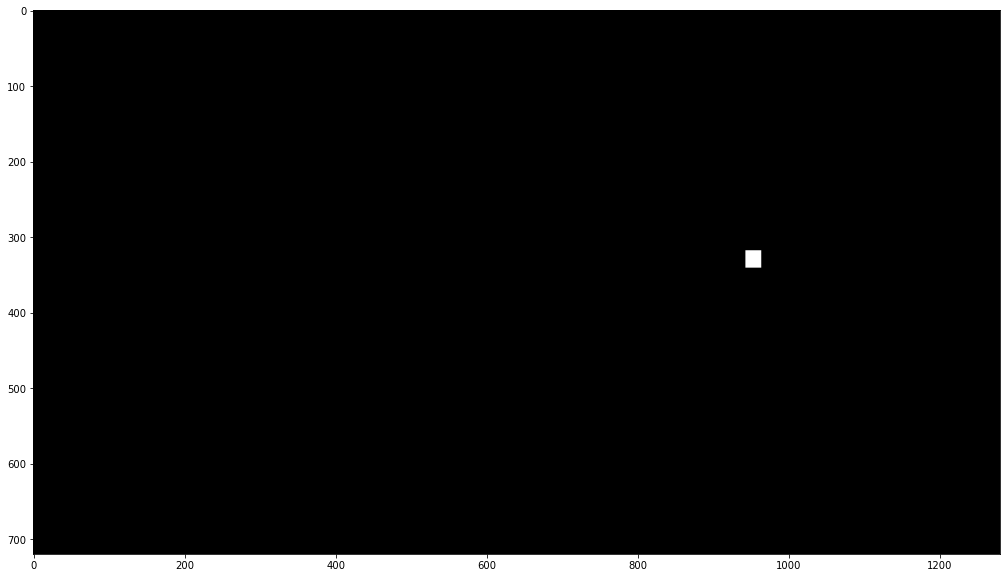

In [52]:
%matplotlib inline
show_tranformed_image0(data_loader_train3)

In [49]:
# Аргументация 
def show_tranformed_image(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
#             sample = sample * 255
#             sample = sample.astype(np.uint8)
            ax.imshow(sample)
            print(sample.shape)
            for box in boxes:
                      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
                      rect = patches.Rectangle((x, y),
                                              width, height,
                                              fc ='none', 
                                              ec ='r',
                                              lw = 3)
                      ax.add_patch(rect)
            plt.axis('off')
            plt.show()

(720, 1280, 3)


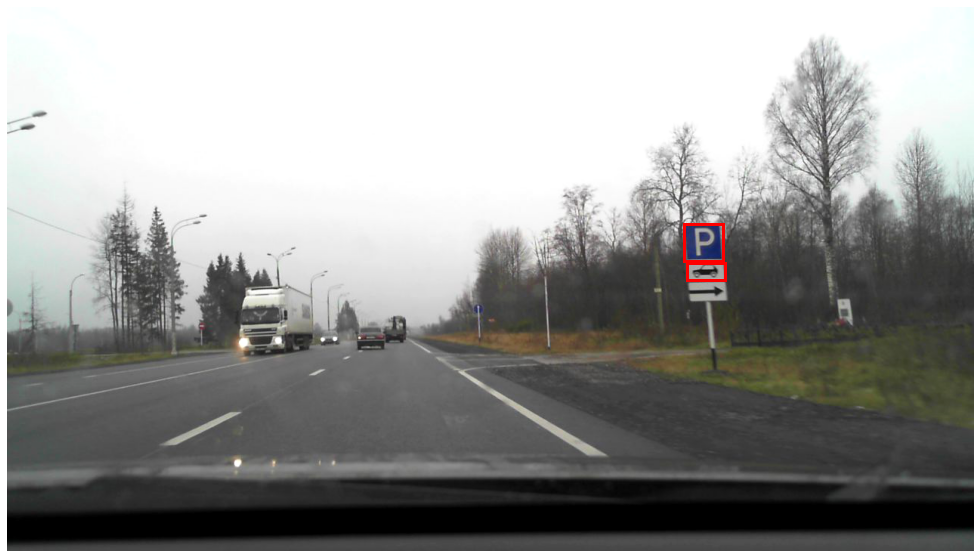

In [55]:
# Аргументация pd
show_tranformed_image(data_loader_train2)

(720, 1280, 3)


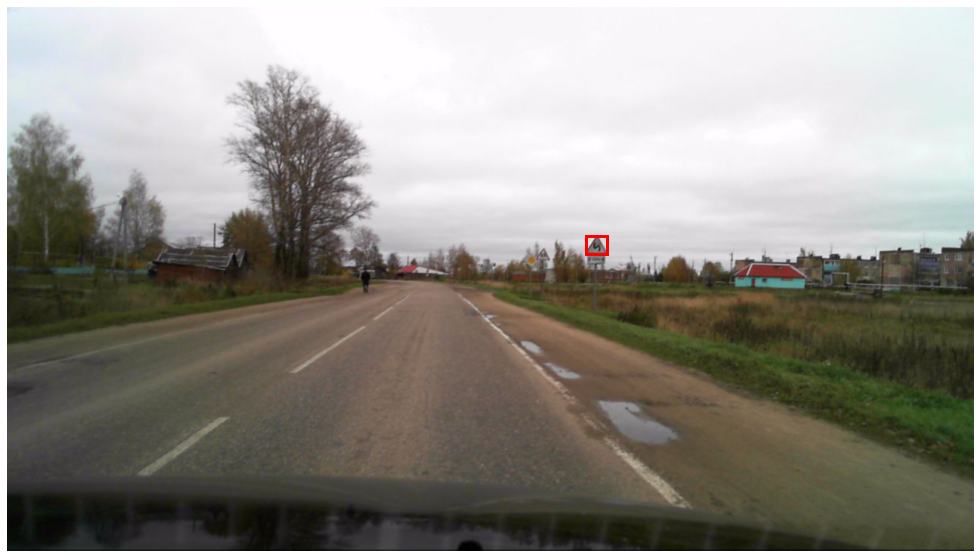

In [56]:
# Аргументация coco
show_tranformed_image(data_loader_train_2)

### DATASET CLASSIFIC

In [41]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 5
batch_size = 30
classes1 = 157
device

'cpu'

In [42]:
# добавление нового знака - "не знак 0_0"
# функция загрузки датасета в pd
def dataset_156(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    dfa = df.reset_index()
    dfa = dfa.drop(['index'],axis=1)
    dfa.iloc[10:50, 4] = dfa.iloc[10:50, 4].apply(lambda x: [int(x[0]-0.5*x[2]), int(x[1]-0.5*x[3]), x[2], x[3]])
    dfa.iloc[10:50, 2] = 156
  
  return dfa

In [43]:
df_a = dataset_156('.', 'train_anno.json')
df_a.head()

,id,image_id,category_id,area,bbox,iscrowd,name,width,height,file_name
0,0,0,1,324,"[649, 376, 18, 18]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1,1,420,"[671, 356, 20, 21]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,2,1,702,"[711, 332, 27, 26]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,3,1,1332,"[764, 290, 37, 36]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,3,2,289,"[684, 384, 17, 17]",0,1_23,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg


#### pandas

In [104]:
class RTSD_dataset_clf_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        boxes = self.df.loc[index,'bbox']
        bb = [boxes[0], boxes[1], boxes[0] + boxes[2], boxes[1] + boxes[3]]
        imgs = Image.open(os.path.join(self.path_img, name_img))
        imgs = imgs.crop(bb)

        if self.transforms is not None:
#             imgs = self.transforms(imgs)
            imgs = np.array(imgs).astype(np.float32)/255.
            imgs = self.transforms(image=imgs)['image']
            imgs = imgs.float()

        imgs = imgs / 255

        targets = torch.tensor(self.df.loc[index, 'category_id'])


#         return imgs, targets
        return {
                'images': imgs,
                'targets': targets}
    
    def __len__(self):
        
        return self.df.shape[0]

In [105]:
def get_transform1():
    return transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [106]:
def get_transform_a1():
             return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(distortion_scale=0.4,p=0.9),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.ColorJitter(brightness=(0.4), contrast=(0.3), saturation=(0.3)),
                                                                                    transforms.ToTensor()
                                                                                    ])
                                                                ])
                                       ])


In [107]:
def get_transform_a_1():
    return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                              A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                              A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                              A.augmentations.transforms.GaussNoise (var_limit=(0.01, 0.2), mean=0, per_channel=False, always_apply=False, p=0.3),
                              A.Rotate(limit=10, p=0.5),
                              ToTensorV2(p=1.0)
                              ])

In [108]:
df12 = RTSD_dataset_clf_my('./', df_a, transforms=get_transform1())
df112 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())
df222 = RTSD_dataset_clf_my('./', df_a, transforms=get_transform_a_1())
df122 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())

In [109]:
data_loader_train12 = torch.utils.data.DataLoader(df12,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val12 = torch.utils.data.DataLoader(df112,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)
data_loader_train22 = torch.utils.data.DataLoader(df222,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val22 = torch.utils.data.DataLoader(df122,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)

#### Визуализация данных (Аргументация)

In [110]:
def show_tranformed_image2(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            data = next(iter(train_loader))
            images, targets = data['images'], data['targets']
            images = list(image.to(device) for image in images)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            targets = [t.to(device) for t in targets]
            targets = targets[i].item()
            
            plt.imshow(sample)
            plt.title(targets)
            plt.axis('off')
            plt.show()

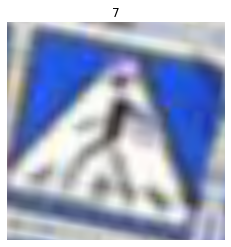

In [111]:
%matplotlib inline
show_tranformed_image2(data_loader_train22)

In [112]:
def show_tranformed_image12(train_loader):
            figure = plt.figure(figsize=(10, 8))
            cols, rows = 3, 3
            if len(train_loader) > 0:
                  for i in range(1, cols * rows + 1):
                              for j in range(1):
                                  data = next(iter(train_loader))
                                  images, targets = data['images'], data['targets']
                                  targets = targets[j].item()
                                  sample = images[j].permute(1, 2, 0).detach().cpu().numpy()
                                  sample = sample * 255
                                  figure.add_subplot(rows, cols, i)
                                                    
                                  plt.imshow(sample)
                                  
                                  plt.title(targets)
                                  plt.axis("off")
            plt.show()

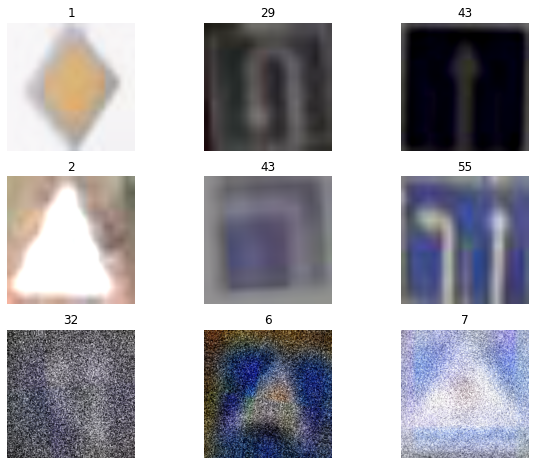

In [113]:
show_tranformed_image12(data_loader_train22)